In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:

# 1. Load Data
train_file = '../poker+hand/poker-hand-training-true.data'
test_file = '../poker+hand/poker-hand-testing.data'

# Assuming a comma-separated format:
train_data = np.loadtxt(train_file, delimiter=',')
X_train = train_data[:, :-1]           # Features: all columns except the last
y_train = train_data[:, -1].astype(int)  # Target: the last column

test_data = np.loadtxt(test_file, delimiter=',')
X_test = test_data[:, :-1]
y_test = test_data[:, -1].astype(int)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (25010, 10) (25010,)
Testing data shape: (1000000, 10) (1000000,)


In [4]:
# 2. Compute Automatic Sample Weights
# Calculate class frequencies
unique_classes, class_counts = np.unique(y_train, return_counts=True)
n_classes = len(unique_classes)
n_samples = len(y_train)

# Compute weights for each class using the formula:
# weight_c = n_samples / (n_classes * count_c)
class_weights = {cls: n_samples / (n_classes * count) for cls, count in zip(unique_classes, class_counts)}
print("Calculated Class Weights:", class_weights)

# Create a sample_weight array where each sample gets the weight corresponding to its class
sample_weight = np.array([class_weights[cls] for cls in y_train])


Calculated Class Weights: {np.int64(0): np.float64(0.20019210758024494), np.int64(1): np.float64(0.2359656571374658), np.int64(2): np.float64(2.07379767827529), np.int64(3): np.float64(4.875243664717349), np.int64(4): np.float64(26.892473118279568), np.int64(5): np.float64(46.31481481481482), np.int64(6): np.float64(69.47222222222223), np.int64(7): np.float64(416.8333333333333), np.int64(8): np.float64(500.2), np.int64(9): np.float64(500.2)}


In [5]:

# 3. Create a Pipeline
# StandardScaler is included to keep the structure similar to previous experiments,
# even though tree-based models are less sensitive to scaling.
pipeline = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(random_state=42)
)

In [9]:
# 4. Define the Hyperparameter Grid for the Gradient Boosting Model
param_grid = {
    'gradientboostingclassifier__n_estimators': [50, 100, 200],
    'gradientboostingclassifier__learning_rate': [0.01, 0.1, 1.0],
    'gradientboostingclassifier__max_depth': [3, 5, 7]
}

In [10]:
# 5. Set Up GridSearchCV with Parallel Processing
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=4)

print("Starting grid search with automatic sample weighting...")
# Pass the sample_weight to the GradientBoostingClassifier within the pipeline:
grid_search.fit(X_train, y_train, **{'gradientboostingclassifier__sample_weight': sample_weight})
print("Grid search complete.")

print("\nBest Parameters Found:")
print(grid_search.best_params_)
print("Best Cross-Validation Score: {:.4f}".format(grid_search.best_score_))


Starting grid search with automatic sample weighting...
Grid search complete.

Best Parameters Found:
{'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__n_estimators': 200}
Best Cross-Validation Score: 0.7042


In [11]:
# 6. Evaluate on Test Data
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nTest Accuracy: {:.4f}".format(accuracy))
print("\nClassification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)


Test Accuracy: 0.7211

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81    501209
           1       0.68      0.68      0.68    422498
           2       0.28      0.19      0.23     47622
           3       0.29      0.11      0.16     21121
           4       0.11      0.04      0.06      3885
           5       0.76      0.21      0.33      1996
           6       0.08      0.01      0.01      1424
           7       0.00      0.00      0.00       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.72   1000000
   macro avg       0.30      0.21      0.23   1000000
weighted avg       0.70      0.72      0.71   1000000

Confusion Matrix:
[[422345  77200   1130    321    113     77      2      1      1     19]
 [112264 286831  18600   3840    791     49     44     10     29     40]
 [   681  36500   8998   1241 

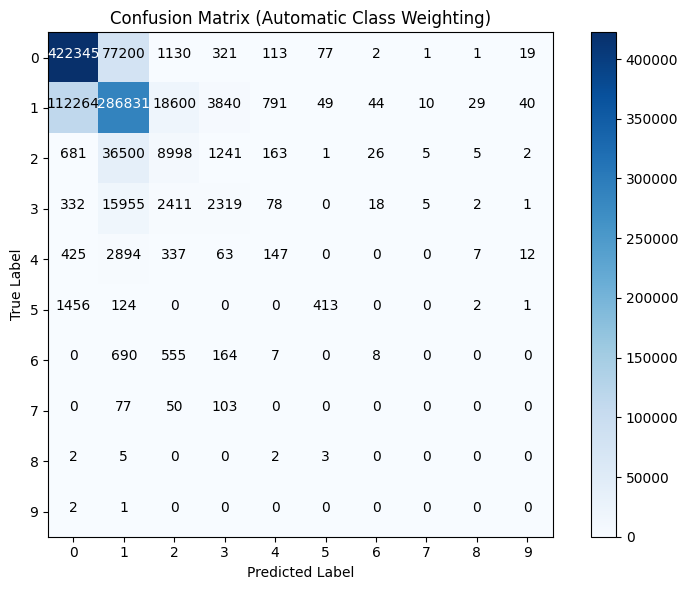

In [8]:
# 7. Visualize the Confusion Matrix using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Automatic Class Weighting)")
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
threshold = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > threshold else "black")
plt.tight_layout()
plt.show()

In [9]:
# 8. Save the Best Model for External Use
model_filename = 'gradient_boosting_weighted_poker_model_automatic.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)
print(f"\nModel saved to {model_filename}")


Model saved to gradient_boosting_weighted_poker_model_automatic.pkl
